# **T5-base Full fine-tuning Evaluate**

From : [JooYoung Song](https://github.com/Song-Joo-Young/ToTTo-Fine-tuning-in-colab/tree/main)

Code Reference :
* ToTTo : https://github.com/google-research-datasets/ToTTo
* BLEURT : https://github.com/google-research/bleurt

## **1.1 Google Drive mound & install library**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers datasets sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00


In [3]:
import json
import os

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import T5Tokenizer

# from preprocess_utils import get_highlighted_subtable, linearize_subtable

## **1.2 Preprocessing code (ToTTo dataset)**

In [ ]:
# Google's Official Preprocess Codes
# https://github.com/google-research/language/blob/master/language/totto/baseline_preprocessing/preprocess_utils.py

import copy

def _add_adjusted_col_offsets(table):
  """Add adjusted column offsets to take into account multi-column cells."""
  adjusted_table = []
  for row in table:
    real_col_index = 0
    adjusted_row = []
    for cell in row:
      adjusted_cell = copy.deepcopy(cell)
      adjusted_cell["adjusted_col_start"] = real_col_index
      adjusted_cell["adjusted_col_end"] = (
          adjusted_cell["adjusted_col_start"] + adjusted_cell["column_span"])
      real_col_index += adjusted_cell["column_span"]
      adjusted_row.append(adjusted_cell)
    adjusted_table.append(adjusted_row)
  return adjusted_table


def _get_heuristic_row_headers(adjusted_table, row_index, col_index):
  """Heuristic to find row headers."""
  row_headers = []
  row = adjusted_table[row_index]
  for i in range(0, col_index):
    if row[i]["is_header"]:
      row_headers.append(row[i])
  return row_headers


def _get_heuristic_col_headers(adjusted_table, row_index, col_index):
  """Heuristic to find column headers."""
  adjusted_cell = adjusted_table[row_index][col_index]
  adjusted_col_start = adjusted_cell["adjusted_col_start"]
  adjusted_col_end = adjusted_cell["adjusted_col_end"]
  col_headers = []
  for r in range(0, row_index):
    row = adjusted_table[r]
    for cell in row:
      if (cell["adjusted_col_start"] < adjusted_col_end and
          cell["adjusted_col_end"] > adjusted_col_start):
        if cell["is_header"]:
          col_headers.append(cell)

  return col_headers


def get_highlighted_subtable(table, cell_indices, with_heuristic_headers=False):
  """Extract out the highlighted part of a table."""
  highlighted_table = []

  adjusted_table = _add_adjusted_col_offsets(table)

  for (row_index, col_index) in cell_indices:
    cell = table[row_index][col_index]
    if with_heuristic_headers:
      row_headers = _get_heuristic_row_headers(adjusted_table, row_index,
                                               col_index)
      col_headers = _get_heuristic_col_headers(adjusted_table, row_index,
                                               col_index)
    else:
      row_headers = []
      col_headers = []

    highlighted_cell = {
        "cell": cell,
        "row_headers": row_headers,
        "col_headers": col_headers
    }
    highlighted_table.append(highlighted_cell)

  return highlighted_table


def linearize_full_table(table, cell_indices, table_page_title,
                         table_section_title):
  """Linearize full table with localized headers and return a string."""
  table_str = ""
  if table_page_title:
    table_str += "<page_title> " + table_page_title + " </page_title> "
  if table_section_title:
    table_str += "<section_title> " + table_section_title + " </section_title> "

  table_str += "<table> "
  adjusted_table = _add_adjusted_col_offsets(table)
  for r_index, row in enumerate(table):
    row_str = "<row> "
    for c_index, col in enumerate(row):

      row_headers = _get_heuristic_row_headers(adjusted_table, r_index, c_index)
      col_headers = _get_heuristic_col_headers(adjusted_table, r_index, c_index)

      # Distinguish between highlighted and non-highlighted cells.
      if [r_index, c_index] in cell_indices:
        start_cell_marker = "<highlighted_cell> "
        end_cell_marker = "</highlighted_cell> "
      else:
        start_cell_marker = "<cell> "
        end_cell_marker = "</cell> "

      # The value of the cell.
      item_str = start_cell_marker + col["value"] + " "

      # All the column headers associated with this cell.
      for col_header in col_headers:
        item_str += "<col_header> " + col_header["value"] + " </col_header> "

      # All the row headers associated with this cell.
      for row_header in row_headers:
        item_str += "<row_header> " + row_header["value"] + " </row_header> "

      item_str += end_cell_marker
      row_str += item_str

    row_str += "</row> "
    table_str += row_str

  table_str += "</table>"
  if cell_indices:
    assert "<highlighted_cell>" in table_str
  return table_str


def linearize_subtable(subtable, table_page_title, table_section_title):
  """Linearize the highlighted subtable and return a string of its contents."""
  table_str = ""
  if table_page_title:
    table_str += "<page_title> " + table_page_title + " </page_title> "
  if table_section_title:
    table_str += "<section_title> " + table_section_title + " </section_title> "
  table_str += "<table> "

  for item in subtable:
    cell = item["cell"]
    row_headers = item["row_headers"]
    col_headers = item["col_headers"]

    # The value of the cell.
    item_str = "<cell> " + cell["value"] + " "

    # All the column headers associated with this cell.
    for col_header in col_headers:
      item_str += "<col_header> " + col_header["value"] + " </col_header> "

    # All the row headers associated with this cell.
    for row_header in row_headers:
      item_str += "<row_header> " + row_header["value"] + " </row_header> "

    item_str += "</cell> "
    table_str += item_str

  table_str += "</table>"
  return table_str

## **1.3 Model & tokenizer setting for generation**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Current GPU Index:", torch.cuda.current_device())
    print("Current GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Current GPU Index: 0
Current GPU Name: Tesla T4


In [ ]:
batch_size = 24 # 10 for 't5-large'

In [ ]:
from transformers import T5Tokenizer, T5Model

# Pre-Trained T5 Tokenizer
tokenizer=T5Tokenizer.from_pretrained('t5-base')
# Add Special Tokens: Table Tags
tokenizer.add_special_tokens({
    'additional_special_tokens': [
        '<page_title>',
        '</page_title>',
        '<section_title>',
        '</section_title>',
        '<table>',
        '</table>',
        '<cell>',
        '</cell>',
        '<col_header>',
        '</col_header>',
        '<row_header>',
        '</row_header>'
    ]
})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the

12

In [ ]:
class ToTToDataset(Dataset):
    """
    For Evaluation (Dev Set)
    """
    def __init__(self, path_data, tokenizer):
        #
        self.data=[]

        # Load Dataset
        with open(path_data, 'r') as f:
            dataset=f.read().splitlines()
            f.close()

        for _data in dataset:
            data=json.loads(_data)

            # Preprocess
            subtable=get_highlighted_subtable(table=data['table'], cell_indices=data['highlighted_cells'], with_heuristic_headers=True)
            cells_linearized=linearize_subtable(
                subtable=subtable,
                table_page_title=data['table_page_title'],
                table_section_title=data['table_section_title']
            )

            # Encode
            encoded=tokenizer.encode(cells_linearized)
            if len(encoded)>512:
                # Truncate
                encoded=encoded[:511]+[tokenizer.eos_token_id]
            self.data.append(encoded)

        print(len(self.data), 'datas')

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

In [ ]:
def collate_fn(batch):
    """
    Same Sequence Length on Same Batch
    """
    max_len_data=0
    for data in batch:
        if len(data)>max_len_data: max_len_data=len(data)

    datas=[]
    attn_masks=[]
    for data in batch:
        data.extend([tokenizer.pad_token_id]*(max_len_data-len(data)))
        datas.append(data)

        attn_mask=[int(e!=tokenizer.pad_token_id) for e in data]
        attn_masks.append(attn_mask)

    return torch.tensor(datas), torch.tensor(attn_masks)

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Pre-Trained T5 Model
model=T5ForConditionalGeneration.from_pretrained('t5-base').to(device)
# Resize PLM's Embedding Layer
model.resize_token_embeddings(len(tokenizer))

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Embedding(32112, 768)

In [ ]:
dataset_dev=ToTToDataset(path_data='/content/drive/MyDrive/ToTTo_T5-base/totto_dev_data.jsonl', tokenizer=tokenizer)
dataloader_dev=DataLoader(dataset_dev, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Token indices sequence length is longer than the specified maximum sequence length for this model (1344 > 512). Running this sequence through the model will result in indexing errors


7700 datas


In [ ]:
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32112, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32112, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

### **Epoch 1 Genration**

In [ ]:
# Trained Model
# 저장된 가중치 파일 로드

model_path = '/content/drive/MyDrive/ToTTo_T5-base/model/T5-base_Fine-Tuning_lr0.0001_batch24_epoch1.pth'
model.load_state_dict(torch.load(model_path))

model = model.to(device)
model.eval()

# Generation
if os.path.exists('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch1.txt'):
    os.remove('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch1.txt')
f=open('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch1.txt', 'a')

with torch.no_grad():
    for idx, (data, attn_mask) in enumerate(dataloader_dev):
        if (idx+1)%100==0: print(batch_size*(idx+1), 'generated')

        data=data.to(device)
        attn_mask=attn_mask.to(device)

        # Beam Search
        outputs=model.generate(
            data,
            max_length=300,
            num_beams=5,
            early_stopping=True
        )

        for generation in tokenizer.batch_decode(outputs, skip_special_tokens=True):
            f.write(generation+'\n')

f.close()

2400 generated
4800 generated
7200 generated


In [ ]:
# 생성 문장의 처음 몇 개를 확인하기 위한 코드
with open('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch1.txt', 'r') as generated_file:
    generated_sentences = [next(generated_file).strip() for _ in range(5)]

# Dev 데이터의 처음 몇 개를 확인하기 위한 코드
for idx, (data, _) in enumerate(dataloader_dev):
    if idx == 5:  # 처음 5개의 데이터만 확인
        break

    data = data.to(device)

    print("\nDev Data Example", idx + 1)
    print("Input Data:", tokenizer.batch_decode(data, skip_special_tokens=True))
    print("Generated Sentences: ", generated_sentences[idx])


Dev Data Example 1
Input Data: ['List of Governors of South Carolina Governors under the Constitution of 1868 76 # 74 75 Daniel Henry Chamberlain Governor 76 December 1, 1874 Took Office 76', 'Alma Jodorowsky Filmography 2016 Year Kids in Love Title Evelyn Role', 'A. J. Hawk Career statistics 119 TOTAL', 'List of rulers of Brittany House of Montfort Peter II the Simple (Pêr II) 1450–1457 Name Arthur III the Justicier (Arzhur III) 1457–1458 Name 26 December 1458 Nantes aged 65 Death', 'List of Speakers of the Minnesota House of Representatives State Ralph J. Parker Speaker', 'Asian Beach Games List of Asian Beach Games 2016 Year Da Nang Host City Vietnam Host Nation 24 September Start Date 3 October End Date 2020 Year Sanya Host City China Host Nation', 'Julian Sands Television 2012 Year Person of Interest Title Alistair Wesley Role Episode: Critical Notes', 'Adrienne Bailon Film roles 2005 Year Coach Carter Title Dominique Role', 'List of ambassadors of the United States to Trinidad a

## **2.1 Evaluation repository**

In [4]:
!git clone https://github.com/Song-Joo-Young/language.git language_repo

Cloning into 'language_repo'...
remote: Enumerating objects: 3851, done.
remote: Counting objects: 100% (835/835), done.
remote: Compressing objects: 100% (474/474), done.
remote: Total 3851 (delta 404), reused 676 (delta 350), pack-reused 3016
Receiving objects: 100% (3851/3851), 6.15 MiB | 14.34 MiB/s, done.
Resolving deltas: 100% (2193/2193), done.


In [5]:
!pip install git+https://github.com/google-research/bleurt.git

  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-b47fz8p5
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/bleurt.git /tmp/pip-req-build-b47fz8p5
  Resolved https://github.com/google-research/bleurt.git to commit cebe7e6f996b40910cfaa520a63db47807e3bf5c
  Preparing metadata (setup.py) ... done
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456765 sha256=96320becd64bf1a5a40b821fe2ee1b45079a4eb3f45f00c0f93d3f28dae523aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-nuvwkt27/wheels/64/f4/2c/509a6c31b8ebde891a81029fd94f199b1b92f0e7cfc20d417a
Successfully built BLEURT


## **2.2 Setting Up the Directory & Requirement for BLEURT**

In [6]:
%cd language_repo

/content/language_repo


In [7]:
# Downloads the BLEURT-base checkpoint.
! wget https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip .
! unzip BLEURT-20.zip

--2024-02-02 11:08:25--  https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.207, 108.177.111.207, 142.250.1.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2140294207 (2.0G) [application/octet-stream]
Saving to: ‘BLEURT-20.zip’

BLEURT-20.zip       100%[===================>]   1.99G  95.9MB/s    in 19s     

2024-02-02 11:08:45 (105 MB/s) - ‘BLEURT-20.zip’ saved [2140294207/2140294207]

--2024-02-02 11:08:45--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2024-02-02 11:08:45--
Total wall clock time: 20s
Downloaded: 1 files, 2.0G in 19s (105 MB/s)
Archive:  BLEURT-20.zip
   creating: BLEURT-20/
  inflating: BLEURT-20/bert_config.json  
  inflating: BLEURT-20/saved_model.pb  
   creating: BLEURT-20/variables/
  inflat

In [8]:
! pip3 install -r language/totto/eval_requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 1.3 MB/s eta 0:00:00


#### **Epoch 1 evaluation**

In [ ]:
# Epoch 1
! bash language/totto/totto_eval.sh --prediction_path /content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch1.txt --target_path /content/drive/MyDrive/ToTTo_T5-base/totto_dev_data.jsonl --bleurt_ckpt BLEURT-20

Running with the following variables:
PREDICTION_PATH   : /content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch1.txt
TARGET_PATH       : /content/drive/MyDrive/ToTTo_T5-base/totto_dev_data.jsonl 
BLEURT_CKPT       : BLEURT-20 
OUTPUT_DIR        : temp
MODE              : test
Creating Output directory.
Cloning moses for BLEU script.
Cloning into 'temp/mosesdecoder'...
remote: Enumerating objects: 148097, done.
remote: Counting objects: 100% (525/525), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 148097 (delta 323), reused 441 (delta 292), pack-reused 147572
Receiving objects: 100% (148097/148097), 129.88 MiB | 14.90 MiB/s, done.
Resolving deltas: 100% (114349/114349), done.
Writing references.
Writing tables in PARENT format.
Preparing predictions.
Writing predictions.
Running detokenizers.
======== EVALUATE OVERALL ========
Computing BLEU (overall)
{
 "name": "BLEU",
 "score": 43.1,
 "signature": "nrefs:3|case:mixed|eff:no|tok:13a|smooth:exp|version:2.4.0

### **Epoch 2 Generation**

In [ ]:
# 런타임 리셋 후 필요한 코드는 1.1 ~ 1.3 에서 실행
# After resetting the runtime, the required code runs on title 1.1 ~ 1.3

In [ ]:
# Trained Model
# 저장된 가중치 파일 로드

model_path = '/content/drive/MyDrive/ToTTo_T5-base/model/T5-base_Fine-Tuning_lr0.0001_batch24_epoch2.pth'
model.load_state_dict(torch.load(model_path))

model = model.to(device)
model.eval()


# Generation
if os.path.exists('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch2.txt'):
    os.remove('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch2.txt')
f=open('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch2.txt', 'a')

with torch.no_grad():
    for idx, (data, attn_mask) in enumerate(dataloader_dev):
        if (idx+1)%100==0: print(batch_size*(idx+1), 'generated')

        data=data.to(device)
        attn_mask=attn_mask.to(device)

        # Beam Search
        outputs=model.generate(
            data,
            max_length=300,
            num_beams=5,
            early_stopping=True
        )

        for generation in tokenizer.batch_decode(outputs, skip_special_tokens=True):
            f.write(generation+'\n')

f.close()

2400 generated
4800 generated
7200 generated


In [ ]:
# 생성 문장의 처음 몇 개를 확인하기 위한 코드
with open('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch2.txt', 'r') as generated_file:
    generated_sentences = [next(generated_file).strip() for _ in range(5)]

# Dev 데이터의 처음 몇 개를 확인하기 위한 코드
for idx, (data, _) in enumerate(dataloader_dev):
    if idx == 5:  # 처음 5개의 데이터만 확인
        break

    data = data.to(device)

    print("\nDev Data Example", idx + 1)
    print("Input Data:", tokenizer.batch_decode(data, skip_special_tokens=True))
    print("Generated Sentences: ", generated_sentences[idx])


Dev Data Example 1
Input Data: ['List of Governors of South Carolina Governors under the Constitution of 1868 76 # 74 75 Daniel Henry Chamberlain Governor 76 December 1, 1874 Took Office 76', 'Alma Jodorowsky Filmography 2016 Year Kids in Love Title Evelyn Role', 'A. J. Hawk Career statistics 119 TOTAL', 'List of rulers of Brittany House of Montfort Peter II the Simple (Pêr II) 1450–1457 Name Arthur III the Justicier (Arzhur III) 1457–1458 Name 26 December 1458 Nantes aged 65 Death', 'List of Speakers of the Minnesota House of Representatives State Ralph J. Parker Speaker', 'Asian Beach Games List of Asian Beach Games 2016 Year Da Nang Host City Vietnam Host Nation 24 September Start Date 3 October End Date 2020 Year Sanya Host City China Host Nation', 'Julian Sands Television 2012 Year Person of Interest Title Alistair Wesley Role Episode: Critical Notes', 'Adrienne Bailon Film roles 2005 Year Coach Carter Title Dominique Role', 'List of ambassadors of the United States to Trinidad a

#### **Epoch 2 evaluation**

In [ ]:
# 런타임 리셋 후 필요한 코드는 2.1, 2.2 에서 실행
# After resetting the runtime, the required code runs on title 2.1, 2.2

In [ ]:
# Epoch 2
! bash language/totto/totto_eval.sh --prediction_path /content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch2.txt --target_path /content/drive/MyDrive/ToTTo_T5-base/totto_dev_data.jsonl --bleurt_ckpt BLEURT-20

Running with the following variables:
PREDICTION_PATH   : /content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch2.txt
TARGET_PATH       : /content/drive/MyDrive/ToTTo_T5-base/totto_dev_data.jsonl 
BLEURT_CKPT       : BLEURT-20 
OUTPUT_DIR        : temp
MODE              : test
Writing references.
Writing tables in PARENT format.
Preparing predictions.
Writing predictions.
Running detokenizers.
======== EVALUATE OVERALL ========
Computing BLEU (overall)
{
 "name": "BLEU",
 "score": 45.6,
 "signature": "nrefs:3|case:mixed|eff:no|tok:13a|smooth:exp|version:2.4.0",
 "verbose_score": "76.2/52.7/39.8/31.0 (BP = 0.966 ratio = 0.967 hyp_len = 124876 ref_len = 129176)",
 "nrefs": "3",
 "case": "mixed",
 "eff": "no",
 "tok": "13a",
 "smooth": "exp",
 "version": "2.4.0"
}
Computing PARENT (overall)
Evaluated 7700 examples.
Precision = 80.99 Recall = 48.67 F-score = 56.78
Computing BLEURT score
2024-02-02 06:51:59.297234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to

### **Epoch 3 Generation**

In [ ]:
# 런타임 리셋 후 필요한 코드는 1.1 ~ 1.3 에서 실행
# After resetting the runtime, the required code runs on title 1.1 ~ 1.3

In [ ]:
# Trained Model
# 저장된 가중치 파일 로드

model_path = '/content/drive/MyDrive/ToTTo_T5-base/model/T5-base_Fine-Tuning_lr0.0001_batch24_epoch3.pth'
model.load_state_dict(torch.load(model_path))

model = model.to(device)
model.eval()

# Generation
if os.path.exists('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch3.txt'):
    os.remove('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch3.txt')
f=open('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch3.txt', 'a')

with torch.no_grad():
    for idx, (data, attn_mask) in enumerate(dataloader_dev):
        if (idx+1)%100==0: print(batch_size*(idx+1), 'generated')

        data=data.to(device)
        attn_mask=attn_mask.to(device)

        # Beam Search
        outputs=model.generate(
            data,
            max_length=300,
            num_beams=5,
            early_stopping=True
        )

        for generation in tokenizer.batch_decode(outputs, skip_special_tokens=True):
            f.write(generation+'\n')

f.close()

2400 generated
4800 generated
7200 generated


In [ ]:
# 생성 문장의 처음 몇 개를 확인하기 위한 코드
with open('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch3.txt', 'r') as generated_file:
    generated_sentences = [next(generated_file).strip() for _ in range(5)]

# Dev 데이터의 처음 몇 개를 확인하기 위한 코드
for idx, (data, _) in enumerate(dataloader_dev):
    if idx == 5:  # 처음 5개의 데이터만 확인
        break

    data = data.to(device)

    print("\nDev Data Example", idx + 1)
    print("Input Data:", tokenizer.batch_decode(data, skip_special_tokens=True))
    print("Generated Sentences: ", generated_sentences[idx])

#### **Epoch 3 evaluation**

In [ ]:
# 런타임 리셋 후 필요한 코드는 2.1, 2.2 에서 실행
# After resetting the runtime, the required code runs on title 2.1, 2.2

In [9]:
# Epoch 3
! bash language/totto/totto_eval.sh --prediction_path /content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch3.txt --target_path /content/drive/MyDrive/ToTTo_T5-base/totto_dev_data.jsonl --bleurt_ckpt BLEURT-20

Running with the following variables:
PREDICTION_PATH   : /content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch3.txt
TARGET_PATH       : /content/drive/MyDrive/ToTTo_T5-base/totto_dev_data.jsonl 
BLEURT_CKPT       : BLEURT-20 
OUTPUT_DIR        : temp
MODE              : test
Creating Output directory.
Cloning moses for BLEU script.
Cloning into 'temp/mosesdecoder'...
remote: Enumerating objects: 148097, done.
remote: Counting objects: 100% (525/525), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 148097 (delta 323), reused 441 (delta 292), pack-reused 147572
Receiving objects: 100% (148097/148097), 129.88 MiB | 16.58 MiB/s, done.
Resolving deltas: 100% (114349/114349), done.
Writing references.
Writing tables in PARENT format.
Preparing predictions.
Writing predictions.
Running detokenizers.
======== EVALUATE OVERALL ========
Computing BLEU (overall)
{
 "name": "BLEU",
 "score": 46.4,
 "signature": "nrefs:3|case:mixed|eff:no|tok:13a|smooth:exp|version:2.4.0

### **Epoch 4 Generation**

In [ ]:
# 런타임 리셋 후 필요한 코드는 1.1 ~ 1.3 에서 실행
# After resetting the runtime, the required code runs on title 1.1 ~ 1.3

In [ ]:
# Trained Model
# 저장된 가중치 파일 로드

model_path = '/content/drive/MyDrive/ToTTo_T5-base/model/T5-base_Fine-Tuning_lr0.0001_batch24_epoch4.pth'
model.load_state_dict(torch.load(model_path))

model = model.to(device)
model.eval()


# Generation
if os.path.exists('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch4.txt'):
    os.remove('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch4.txt')
f=open('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch4.txt', 'a')

with torch.no_grad():
    for idx, (data, attn_mask) in enumerate(dataloader_dev):
        if (idx+1)%100==0: print(batch_size*(idx+1), 'generated')

        data=data.to(device)
        attn_mask=attn_mask.to(device)

        # Beam Search
        outputs=model.generate(
            data,
            max_length=300,
            num_beams=5,
            early_stopping=True
        )

        for generation in tokenizer.batch_decode(outputs, skip_special_tokens=True):
            f.write(generation+'\n')

f.close()

2400 generated
4800 generated
7200 generated


In [ ]:
# 생성 문장의 처음 몇 개를 확인하기 위한 코드
with open('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch4.txt', 'r') as generated_file:
    generated_sentences = [next(generated_file).strip() for _ in range(5)]

# Dev 데이터의 처음 몇 개를 확인하기 위한 코드
for idx, (data, _) in enumerate(dataloader_dev):
    if idx == 5:  # 처음 5개의 데이터만 확인
        break

    data = data.to(device)

    print("\nDev Data Example", idx + 1)
    print("Input Data:", tokenizer.batch_decode(data, skip_special_tokens=True))
    print("Generated Sentences: ", generated_sentences[idx])


Dev Data Example 1
Input Data: ['List of Governors of South Carolina Governors under the Constitution of 1868 76 # 74 75 Daniel Henry Chamberlain Governor 76 December 1, 1874 Took Office 76', 'Alma Jodorowsky Filmography 2016 Year Kids in Love Title Evelyn Role', 'A. J. Hawk Career statistics 119 TOTAL', 'List of rulers of Brittany House of Montfort Peter II the Simple (Pêr II) 1450–1457 Name Arthur III the Justicier (Arzhur III) 1457–1458 Name 26 December 1458 Nantes aged 65 Death', 'List of Speakers of the Minnesota House of Representatives State Ralph J. Parker Speaker', 'Asian Beach Games List of Asian Beach Games 2016 Year Da Nang Host City Vietnam Host Nation 24 September Start Date 3 October End Date 2020 Year Sanya Host City China Host Nation', 'Julian Sands Television 2012 Year Person of Interest Title Alistair Wesley Role Episode: Critical Notes', 'Adrienne Bailon Film roles 2005 Year Coach Carter Title Dominique Role', 'List of ambassadors of the United States to Trinidad a

#### **Epoch 4 evaluation**

In [ ]:
# 런타임 리셋 후 필요한 코드는 2.1, 2.2 에서 실행
# After resetting the runtime, the required code runs on title 2.1, 2.2

In [10]:
# Epoch 4
! bash language/totto/totto_eval.sh --prediction_path /content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch4.txt --target_path /content/drive/MyDrive/ToTTo_T5-base/totto_dev_data.jsonl --bleurt_ckpt BLEURT-20

Running with the following variables:
PREDICTION_PATH   : /content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch4.txt
TARGET_PATH       : /content/drive/MyDrive/ToTTo_T5-base/totto_dev_data.jsonl 
BLEURT_CKPT       : BLEURT-20 
OUTPUT_DIR        : temp
MODE              : test
Writing references.
Writing tables in PARENT format.
Preparing predictions.
Writing predictions.
Running detokenizers.
======== EVALUATE OVERALL ========
Computing BLEU (overall)
{
 "name": "BLEU",
 "score": 47.1,
 "signature": "nrefs:3|case:mixed|eff:no|tok:13a|smooth:exp|version:2.4.0",
 "verbose_score": "77.7/54.6/41.6/32.8 (BP = 0.959 ratio = 0.960 hyp_len = 124055 ref_len = 129219)",
 "nrefs": "3",
 "case": "mixed",
 "eff": "no",
 "tok": "13a",
 "smooth": "exp",
 "version": "2.4.0"
}
Computing PARENT (overall)
Evaluated 7700 examples.
Precision = 81.09 Recall = 49.36 F-score = 57.46
Computing BLEURT score
2024-02-02 14:08:37.150639: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to

### **Epoch 5 Generation**

In [ ]:
# 런타임 리셋 후 필요한 코드는 1.1 ~ 1.3 에서 실행
# After resetting the runtime, the required code runs on title 1.1 ~ 1.3

In [ ]:
# Trained Model
# 저장된 가중치 파일 로드

model_path = '/content/drive/MyDrive/ToTTo_T5-base/model/T5-base_Fine-Tuning_lr0.0001_batch24_epoch5.pth'
model.load_state_dict(torch.load(model_path))

model = model.to(device)
model.eval()

# Generation
if os.path.exists('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch5.txt'):
    os.remove('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch5.txt')
f=open('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch5.txt', 'a')

with torch.no_grad():
    for idx, (data, attn_mask) in enumerate(dataloader_dev):
        if (idx+1)%100==0: print(batch_size*(idx+1), 'generated')

        data=data.to(device)
        attn_mask=attn_mask.to(device)

        # Beam Search
        outputs=model.generate(
            data,
            max_length=300,
            num_beams=5,
            early_stopping=True
        )

        for generation in tokenizer.batch_decode(outputs, skip_special_tokens=True):
            f.write(generation+'\n')

f.close()

2400 generated
4800 generated
7200 generated


In [ ]:
# 생성 문장의 처음 몇 개를 확인하기 위한 코드
with open('/content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch5.txt', 'r') as generated_file:
    generated_sentences = [next(generated_file).strip() for _ in range(5)]

# Dev 데이터의 처음 몇 개를 확인하기 위한 코드
for idx, (data, _) in enumerate(dataloader_dev):
    if idx == 5:  # 처음 5개의 데이터만 확인
        break

    data = data.to(device)

    print("\nDev Data Example", idx + 1)
    print("Input Data:", tokenizer.batch_decode(data, skip_special_tokens=True))
    print("Generated Sentences: ", generated_sentences[idx])

#### **Epoch 5 evaluation**

In [ ]:
# 런타임 리셋 후 필요한 코드는 2.1, 2.2 에서 실행
# After resetting the runtime, the required code runs on title 2.1, 2.2

In [11]:
# Epoch 5
! bash language/totto/totto_eval.sh --prediction_path /content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch5.txt --target_path /content/drive/MyDrive/ToTTo_T5-base/totto_dev_data.jsonl --bleurt_ckpt BLEURT-20

Running with the following variables:
PREDICTION_PATH   : /content/drive/MyDrive/ToTTo_T5-base/generation_dev_epoch5.txt
TARGET_PATH       : /content/drive/MyDrive/ToTTo_T5-base/totto_dev_data.jsonl 
BLEURT_CKPT       : BLEURT-20 
OUTPUT_DIR        : temp
MODE              : test
Writing references.
Writing tables in PARENT format.
Preparing predictions.
Writing predictions.
Running detokenizers.
======== EVALUATE OVERALL ========
Computing BLEU (overall)
{
 "name": "BLEU",
 "score": 47.3,
 "signature": "nrefs:3|case:mixed|eff:no|tok:13a|smooth:exp|version:2.4.0",
 "verbose_score": "77.6/54.5/41.6/32.8 (BP = 0.965 ratio = 0.966 hyp_len = 125138 ref_len = 129596)",
 "nrefs": "3",
 "case": "mixed",
 "eff": "no",
 "tok": "13a",
 "smooth": "exp",
 "version": "2.4.0"
}
Computing PARENT (overall)
Evaluated 7700 examples.
Precision = 81.09 Recall = 49.73 F-score = 57.73
Computing BLEURT score
2024-02-02 17:02:14.842998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to

## **Result visualization**

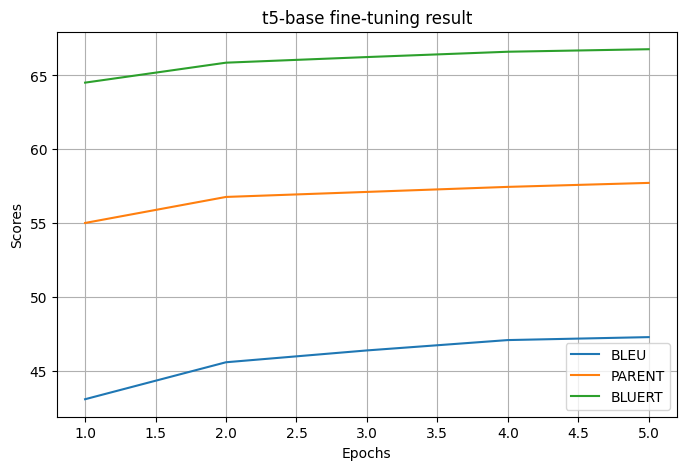

In [5]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 6)]
bleu_scores = [43.1, 45.6, 46.4, 47.1, 47.3]
parent_scores = [55.02, 56.78, 57.12, 57.46, 57.73]
bluert_scores = [0.6451, 0.6586, 0.6624, 0.6660, 0.6677]

bleurt_scores_scaled = [score * 100 for score in bluert_scores]

plt.figure(figsize=(8, 5))
plt.plot(epochs, bleu_scores, label='BLEU')
plt.plot(epochs, parent_scores, label='PARENT')
plt.plot(epochs, bleurt_scores_scaled, label='BLUERT')
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.title('t5-base fine-tuning result')
plt.legend()
plt.grid(True)
plt.show()

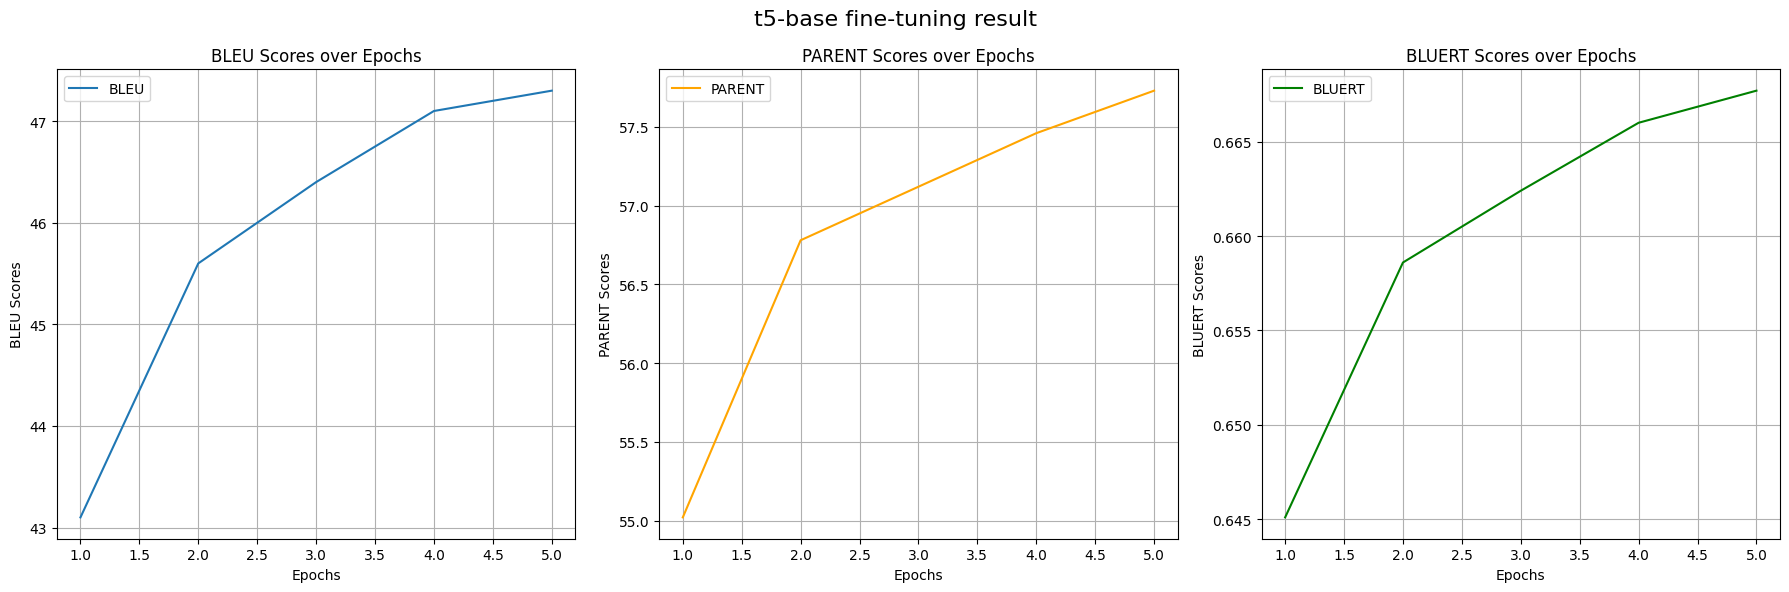

In [4]:
plt.figure(figsize=(18, 6))

# BLEU
plt.subplot(1, 3, 1)
plt.plot(epochs, bleu_scores, label='BLEU')
plt.xlabel('Epochs')
plt.ylabel('BLEU Scores')
plt.title('BLEU Scores over Epochs')
plt.legend()
plt.grid(True)

# PARENT
plt.subplot(1, 3, 2)
plt.plot(epochs, parent_scores, label='PARENT', color='orange')
plt.xlabel('Epochs')
plt.ylabel('PARENT Scores')
plt.title('PARENT Scores over Epochs')
plt.legend()
plt.grid(True)

# BLUERT
plt.subplot(1, 3, 3)
plt.plot(epochs, bluert_scores, label='BLUERT', color='green')
plt.xlabel('Epochs')
plt.ylabel('BLUERT Scores')
plt.title('BLUERT Scores over Epochs')
plt.legend()
plt.grid(True)

plt.suptitle('t5-base fine-tuning result', fontsize=16)
plt.tight_layout()
plt.show()